In [1]:
%run mqtt_thingy.ipynb

In [2]:
%cd ./util_interfaces/
%run advance_dashboard.ipynb

/home/dlar58/Documents/transformable-robot-hardware/Hardware_Control_ESP32/util_interfaces
info
        
        Always be aware that this version of dashboard is instanced when defination.
        Which means that there cannot be two dashboard in the same ipynb kernel.
        
        


Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

In [3]:
    # BL=Responder(("10.144.113.5",1885),"ho1_ret")
    # BL.to="ho1"

In [4]:
    BL=Responder(("10.144.113.5",1885),"ho1_ret")
    BL.to="ho1"

/tmp/ipykernel_542052/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


In [5]:
    BR=Responder(("10.144.113.5",1885),"ho3_ret")
    BR.to="ho3"

Connected successfully!


/tmp/ipykernel_542052/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


In [6]:
    FL=Responder(("10.144.113.5",1885),"ho4_ret")
    FL.to="ho4"

Connected successfully!


/tmp/ipykernel_542052/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


In [7]:
    FR=Responder(("10.144.113.5",1885),"ho2_ret")
    FR.to="ho2"

Connected successfully!


/tmp/ipykernel_542052/1161333552.py:8: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


In [8]:
def rett(task):
    k=ipywidgets.Textarea(layout=ipywidgets.Layout(width='500px', height='100px'))
    task.start()
    return (k,)

@TaskHandlerButtonAdvanced.add_to_state_button(s, rett)
async def control_loop(task, sleep_interval=0.05, keep_len=10):
    global actions
    obs = task.widgets[0]
    
    @loop(sleep_interval)
    def go():
        obs.value="\n".join([str(i) for i in BL.ret_list][::-1])
    
    # await asyncio.gather(R.loop_recv(),go())
    await asyncio.gather(go())
t=control_loop("control_loop")

Connected successfully!


In [9]:
await asyncio.sleep(0.1)

In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import time


In [11]:
await asyncio.sleep(1)

In [12]:
s.display()

Box(children=(Button(description='buttoner', disabled=True, layout=Layout(height='30px', width='auto'), style=…

Box(children=(StateButton(description='loop_timer', layout=Layout(height='30px'), style=ButtonStyle(button_col…

Box(children=(StateButton(description='control_loop', layout=Layout(height='30px'), style=ButtonStyle(button_c…

In [13]:
#%% Define constants and parameters


#%% Define constants and parameters

n = 5 # for one single leg

# Frequency
omega_val = 2 * np.pi
omegaBL = np.ones(n) * omega_val
omegaBR = np.ones(n) * omega_val
omegaFL = np.ones(n) * omega_val
omegaFR = np.ones(n) * omega_val


# Convergence rate
mu_const = 1
muBL = np.ones(n) * mu_const
muBR = np.ones(n) * mu_const
muFL = np.ones(n) * mu_const
muFR = np.ones(n) * mu_const

mu = np.ones(n) * mu_const


# Amplitude
a_val = 10
a_paramBL = np.ones(n) * a_val
a_paramBR = np.ones(n) * a_val
a_paramFL = np.ones(n) * a_val
a_paramFR = np.ones(n) * a_val



# # snake Side-Winding

R_val = 25

r1 = 15
r2 = 0
r3 = r1
r4 = 0
r5 = 0

# bipedal walk
R_ampBL = np.array([r1, r2, r3, r4, r5])      # r1
R_ampBR = np.array([-r1, r2, -r3, r4, -r5])   # r4
R_ampFL = np.array([r1, r2, r3, r4, r5])      # r2
R_ampFR = np.array([-r1, r2, -r3, r4, -r5])   # r3


of1 = 60
of2 = 60
of3 = of1
of4 = 85
of5 = 90

OffsetsBL = np.array([of1, -of2, of3, -of4, -of5]) 
OffsetsBR = np.array([-of1, -of2, -of3, -of4, of5])
OffsetsFL = np.array([-of1, -of2, -of3, -of4, of5])
OffsetsFR = np.array([of1, -of2, of3, -of4, -of5]) 


# high-level phase: BL,BR,FL,FR
# To change the initial condition of integration, as a high level CPG parameter
phi_tilde_high = [0, np.pi/2, 3*np.pi/2, 2*np.pi/2]   



# Low level CPG

phi_tilde_BL = [0, 0.5*np.pi, 0, 0.5*np.pi, 0]
phi_tilde_BR = [0, 0.5*np.pi, 0, 0, 0]
phi_tilde_FL = [0, 0.5*np.pi, 0, 0.5*np.pi, 0]
phi_tilde_FR = [0, 0.5*np.pi, 0, 0, 0]

# # Desired phase differences
theta_tilde_BL=[phi_tilde_BL[i+1]-phi_tilde_BL[i] for i in range(4)]
theta_tilde_BR=[phi_tilde_BR[i+1]-phi_tilde_BR[i] for i in range(4)]
theta_tilde_FL=[phi_tilde_FL[i+1]-phi_tilde_FL[i] for i in range(4)]
theta_tilde_FR=[phi_tilde_FR[i+1]-phi_tilde_FR[i] for i in range(4)]



#%% ODE setup
phi0_BL = np.zeros(n)   # initial phases
r0_BL   = np.zeros(n)   # initial amplitudes
dr0_BL  = np.zeros(n)   # initial amplitude derivatives

x0_BL = np.concatenate((phi0_BL, r0_BL, dr0_BL))


phi0_BR = np.zeros(n) + phi_tilde_high[1]   # initial phases
r0_BR   = np.zeros(n)   # initial amplitudes
dr0_BR  = np.zeros(n)   # initial amplitude derivatives

x0_BR = np.concatenate((phi0_BR, r0_BR, dr0_BR))


phi0_FL = np.zeros(n) + phi_tilde_high[2]  # initial phases
r0_FL   = np.zeros(n)   # initial amplitudes
dr0_FL  = np.zeros(n)   # initial amplitude derivatives

x0_FL = np.concatenate((phi0_FL, r0_FL, dr0_FL))


phi0_FR = np.zeros(n) + phi_tilde_high[3]   # initial phases
r0_FR   = np.zeros(n)   # initial amplitudes
dr0_FR  = np.zeros(n)   # initial amplitude derivatives

x0_FR = np.concatenate((phi0_FR, r0_FR, dr0_FR))


dt = 0.025 # time step

In [14]:
#%% Matrices A and B
A = np.zeros((n, n))
A[0, 0] = -mu[0]
if n >= 2:
    A[0, 1] = mu[1]
for i in range(1, n - 1):
    A[i, i - 1] = mu[i]
    A[i, i]     = -2 * mu[i]
    A[i, i + 1] = mu[i]
A[n - 1, n - 2] = mu[n - 1]
A[n - 1, n - 1] = -mu[n - 1]

B = np.zeros((n, n - 1))
B[0, 0] = 1
for i in range(1, n - 1):
    B[i, i - 1] = -1
    B[i, i]     = 1
B[n - 1, n - 2] = -1


t_span = (0, 20)  # simulate for 20 seconds
t_eval = np.linspace(t_span[0], t_span[1], int(t_span[1]/dt)) # time points: based on dt and t_span

#%% ODE function definition
def cpgODE(t, x, omega, A, B, theta_tilde, a_param, R_amp, n):
    """
    Compute the derivatives for the CPG system.
    x is [phi, r, dr] with each block of length n.
    Returns: [dphi; dr; ddr]
    """
    phi = x[0:n]
    r   = x[n:2*n]
    dr  = x[2*n:3*n]

    # Phase derivatives
    dphi = omega + A.dot(phi) + B.dot(theta_tilde)

    # Second derivatives for amplitude
    ddr = a_param * ((a_param / 4) * (R_amp - r) - dr)

    # Note: The derivative of r is dr (not r)
    return np.concatenate((dphi, dr, ddr))

#%% Solve the ODE
sol_BL = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaBL, A, B, theta_tilde_BL, a_paramBL, R_ampBL, n),
    t_span,
    x0_BL,
    t_eval=t_eval
)

sol_BR = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaBR, A, B, theta_tilde_BR, a_paramBR, R_ampBR, n),
    t_span,
    x0_BR,
    t_eval=t_eval
)


sol_FL = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaFL, A, B, theta_tilde_FL, a_paramFL, R_ampFL, n),
    t_span,
    x0_FL,
    t_eval=t_eval
)

sol_FR = solve_ivp(
    lambda t, y: cpgODE(t, y, omegaFR, A, B, theta_tilde_FR, a_paramFR, R_ampFR, n),
    t_span,
    x0_FR,
    t_eval=t_eval
)


t_BL = sol_BL.t
x_BL = sol_BL.y.T  # shape (time_points, 3*n)

t_BR = sol_BR.t
x_BR = sol_BR.y.T  # shape (time_points, 3*n)

t_FL = sol_FL.t
x_FL = sol_FL.y.T  # shape (time_points, 3*n)

t_FR = sol_FR.t
x_FR = sol_FR.y.T  # shape (time_points, 3*n)


#%% Extract the results
phi_BL = x_BL[:, :n]          # phases
r_BL   = x_BL[:, n:2*n]       # amplitudes
dr_BL  = x_BL[:, 2*n:3*n]     # amplitude derivatives


#%% Extract the results
phi_BR = x_BR[:, :n]          # phases
r_BR   = x_BR[:, n:2*n]       # amplitudes
dr_BR  = x_BR[:, 2*n:3*n]     # amplitude derivatives


#%% Extract the results
phi_FL = x_FL[:, :n]          # phases
r_FL   = x_FL[:, n:2*n]       # amplitudes
dr_FL  = x_FL[:, 2*n:3*n]     # amplitude derivatives


#%% Extract the results
phi_FR = x_FR[:, :n]          # phases
r_FR   = x_FR[:, n:2*n]       # amplitudes
dr_FR  = x_FR[:, 2*n:3*n]     # amplitude derivatives


# Compute the rhythmic output signals: x_i = r_i * sin(phi_i)
desired_angle_BL = r_BL * np.sin(phi_BL) + np.ones(phi_BL.shape)*OffsetsBL
desired_angle_BR = r_BR * np.sin(phi_BR) + np.ones(phi_BR.shape)*OffsetsBR

desired_angle_FL = r_FL * np.sin(phi_FL) + np.ones(phi_FL.shape)*OffsetsFL
desired_angle_FR = r_FR * np.sin(phi_FR) + np.ones(phi_FR.shape)*OffsetsFR


normalize_min = -135
normalize_max = 135

In [15]:
OffsetsBL

array([ 60, -60,  60, -85, -90])

In [16]:
# Normalize the output from -1 to 1
desired_angle_BL_normalized = (desired_angle_BL - normalize_min) / (normalize_max - normalize_min) * 2 - 1
desired_angle_BR_normalized = (desired_angle_BR - normalize_min) / (normalize_max - normalize_min) * 2 - 1
desired_angle_FL_normalized = (desired_angle_FL - normalize_min) / (normalize_max - normalize_min) * 2 - 1
desired_angle_FR_normalized = (desired_angle_FR - normalize_min) / (normalize_max - normalize_min) * 2 - 1

# Change the decimal length
desired_angle_BL_normalized = np.round(desired_angle_BL_normalized,4)
desired_angle_BR_normalized = np.round(desired_angle_BR_normalized,4)
desired_angle_FL_normalized = np.round(desired_angle_FL_normalized,4)
desired_angle_FR_normalized = np.round(desired_angle_FR_normalized,4)

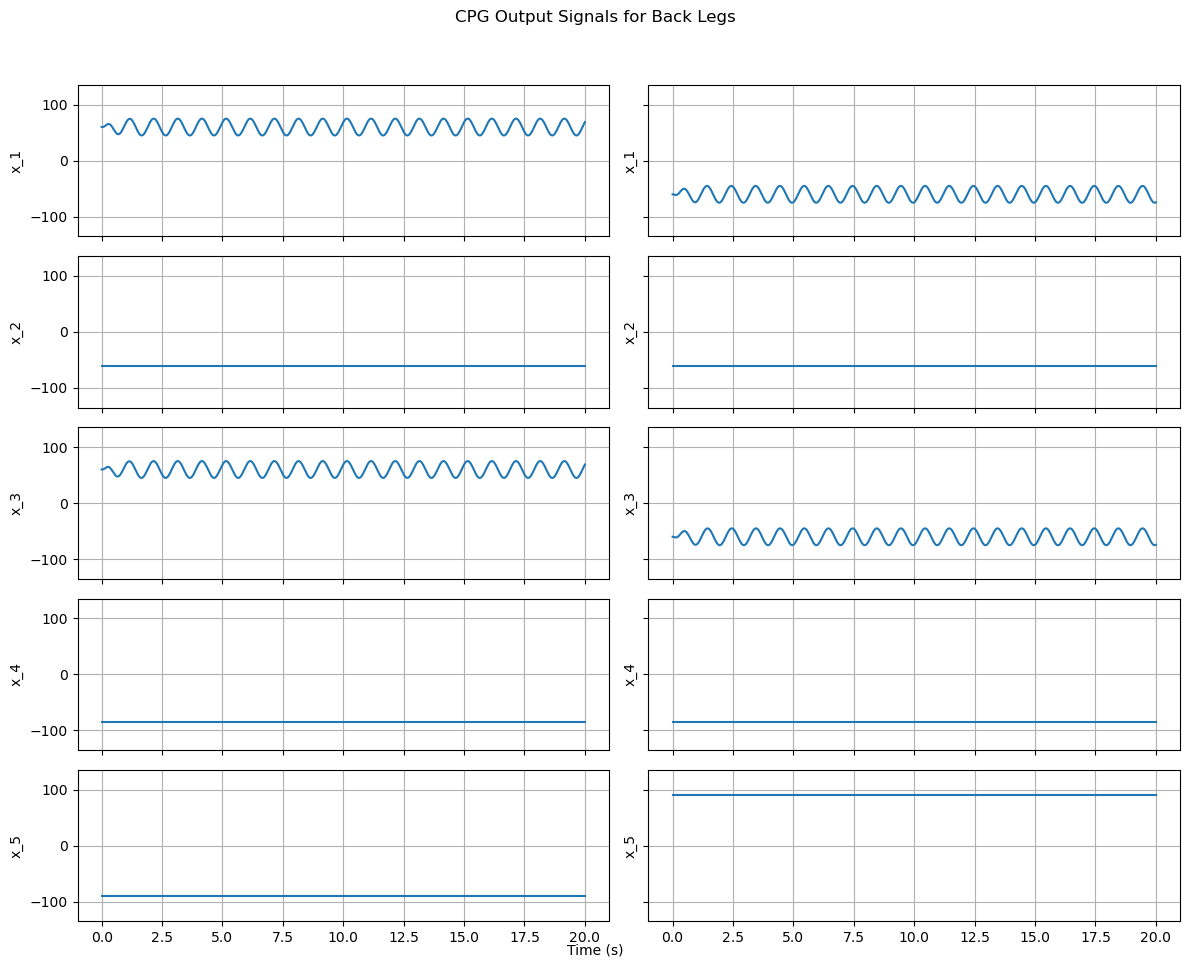

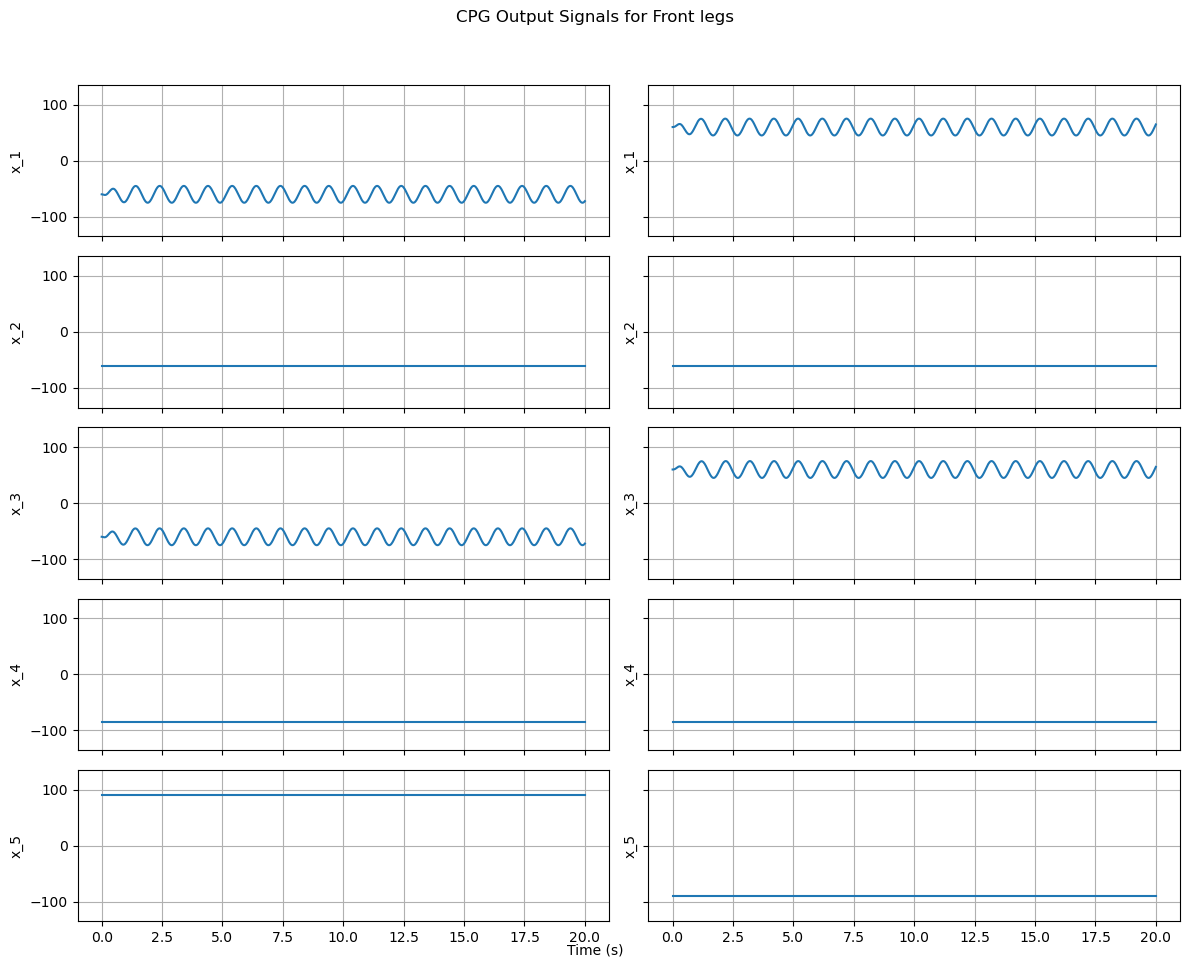

In [17]:
# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot(t_BL, desired_angle_BL[:, i], linewidth=1.5)
    axs[i, 0].set_ylabel(f'x_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot(t_BR, desired_angle_BR[:, i], linewidth=1.5)
    axs[i, 1].set_ylabel(f'x_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Back Legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot(t_FL, desired_angle_FL[:, i], linewidth=1.5)
    axs[i, 0].set_ylabel(f'x_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot(t_FR, desired_angle_FR[:, i], linewidth=1.5)
    axs[i, 1].set_ylabel(f'x_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Front legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
n

5

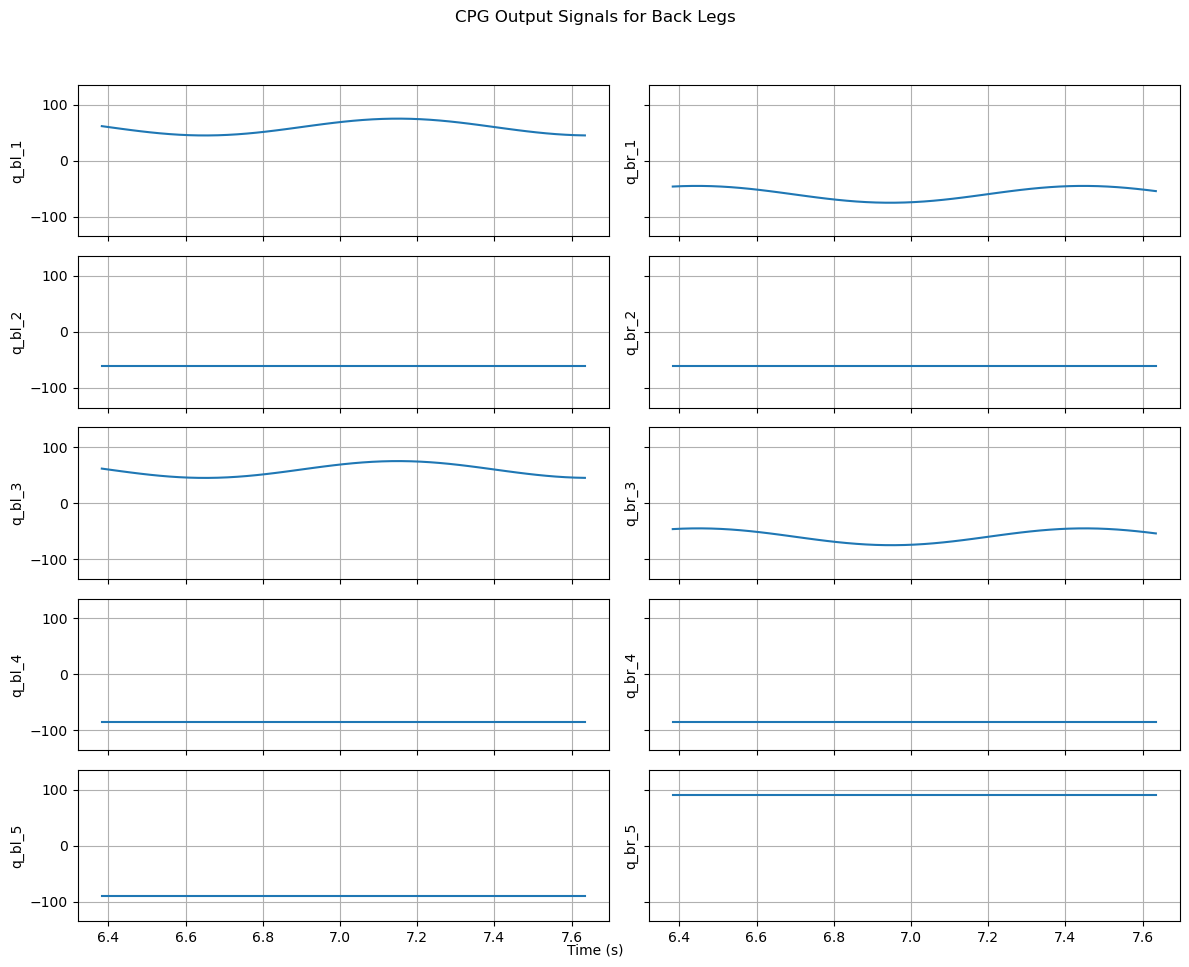

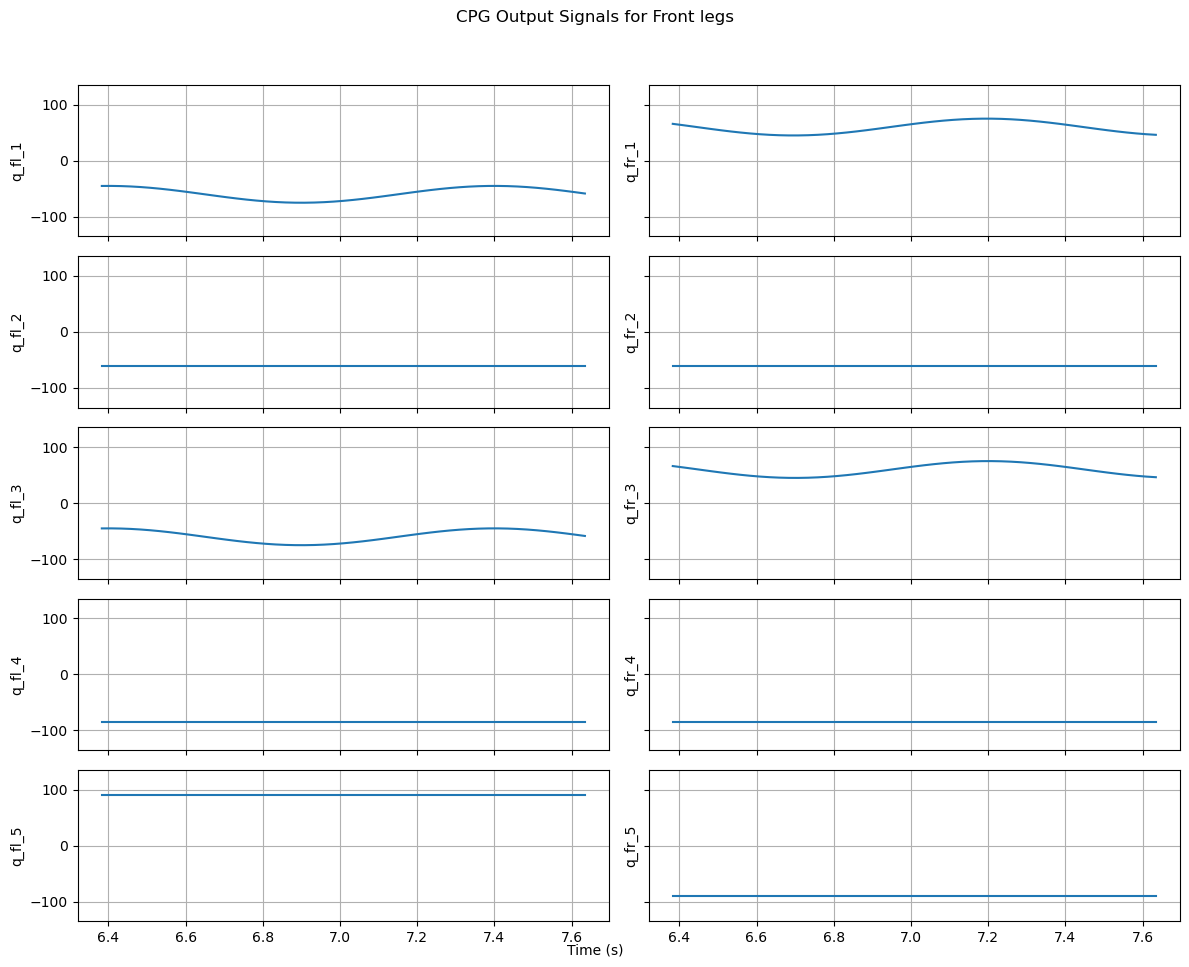

In [19]:
pps = int(2*np.pi/(phi_BR[11,1]-phi_BR[10,1]))


# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot(t_BL[5*pps:6*pps], desired_angle_BL[5*pps:6*pps, i], linewidth=1.5)
    axs[i, 0].set_ylabel(f'q_bl_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot(t_BR[5*pps:6*pps], desired_angle_BR[5*pps:6*pps, i], linewidth=1.5)
    axs[i, 1].set_ylabel(f'q_br_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Back Legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot(t_FL[5*pps:6*pps], desired_angle_FL[5*pps:6*pps, i], linewidth=1.5)
    axs[i, 0].set_ylabel(f'q_fl_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot(t_FR[5*pps:6*pps], desired_angle_FR[5*pps:6*pps, i], linewidth=1.5)
    axs[i, 1].set_ylabel(f'q_fr_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Front legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
bl = np.round(OffsetsBL/135,4)
br = np.round(OffsetsBR/135,4)
fl = np.round(OffsetsFL/135,4)
fr = np.round(OffsetsFR/135,4)

BL.send_exe(f"esp.pca_moves({bl.tolist()})")
BR.send_exe(f"esp.pca_moves({br.tolist()})")
FL.send_exe(f"esp.pca_moves({fl.tolist()})")
FR.send_exe(f"esp.pca_moves({fr.tolist()})")

In [21]:
bl = np.round(OffsetsBL/135,4)

In [22]:
bl

array([ 0.4444, -0.4444,  0.4444, -0.6296, -0.6667])

In [23]:
l1=[
    [0.3, -0.7, -0.3, -0.7, -0.7],
     [0.5, -0.6, -0.1, -0.7, -0.7],
     [0.7, -0.7, 0.7, -0.7, -0.7],
     [0.4, -0.7, 0.7, -0.7, -0.7],
     [0.3, -0.7, 0.2, -0.7, -0.7]
]

l2=[
    [-0.3, -0.7, 0.3, -0.7, 0.7],
 [-0.5, -0.6, 0.1, -0.7, 0.7],
 [-0.7, -0.7, -0.7, -0.7, 0.7],
 [-0.4, -0.7, -0.7, -0.7, 0.7],
 [-0.3, -0.7, -0.2, -0.7, 0.7] 
]

l3=[
    [0.3, -0.7, -0.3, -0.7, -0.7],
 [0.5, -0.6, -0.1, -0.7, -0.7],
 [0.7, -0.7, 0.7, -0.7, -0.7],
 [0.4, -0.7, 0.7, -0.7, -0.7],
 [0.3, -0.7, 0.2, -0.7, -0.7]
]

l4=[
    [-0.3, -0.7, 0.3, -0.7, 0.7],
 [-0.5, -0.6, 0.1, -0.7, 0.7],
 [-0.7, -0.7, -0.7, -0.7, 0.7],
 [-0.4, -0.7, -0.7, -0.7, 0.7],
[-0.3, -0.7, -0.2, -0.7, 0.7]
]
bl,br,fl,fr=l1,l4,l2,l3

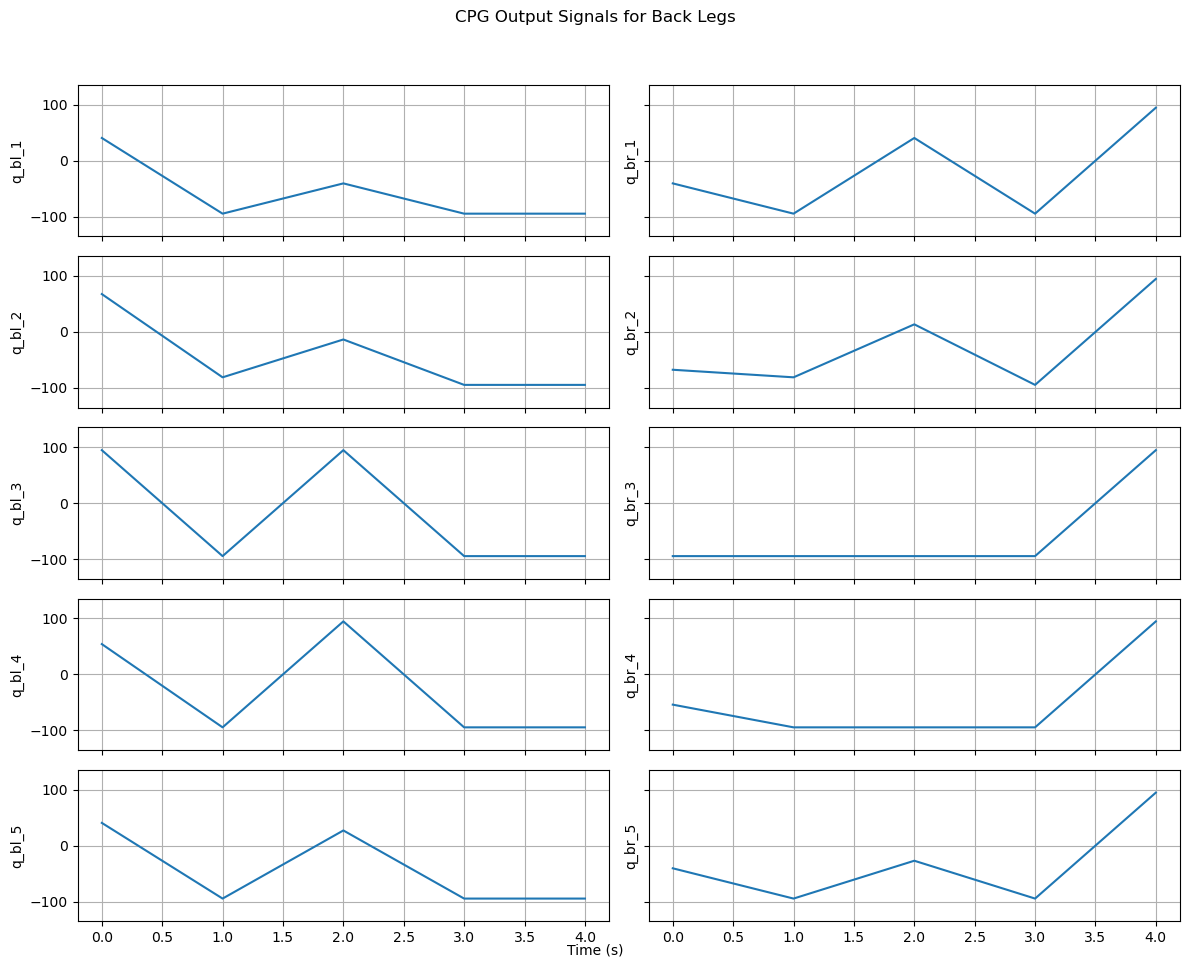

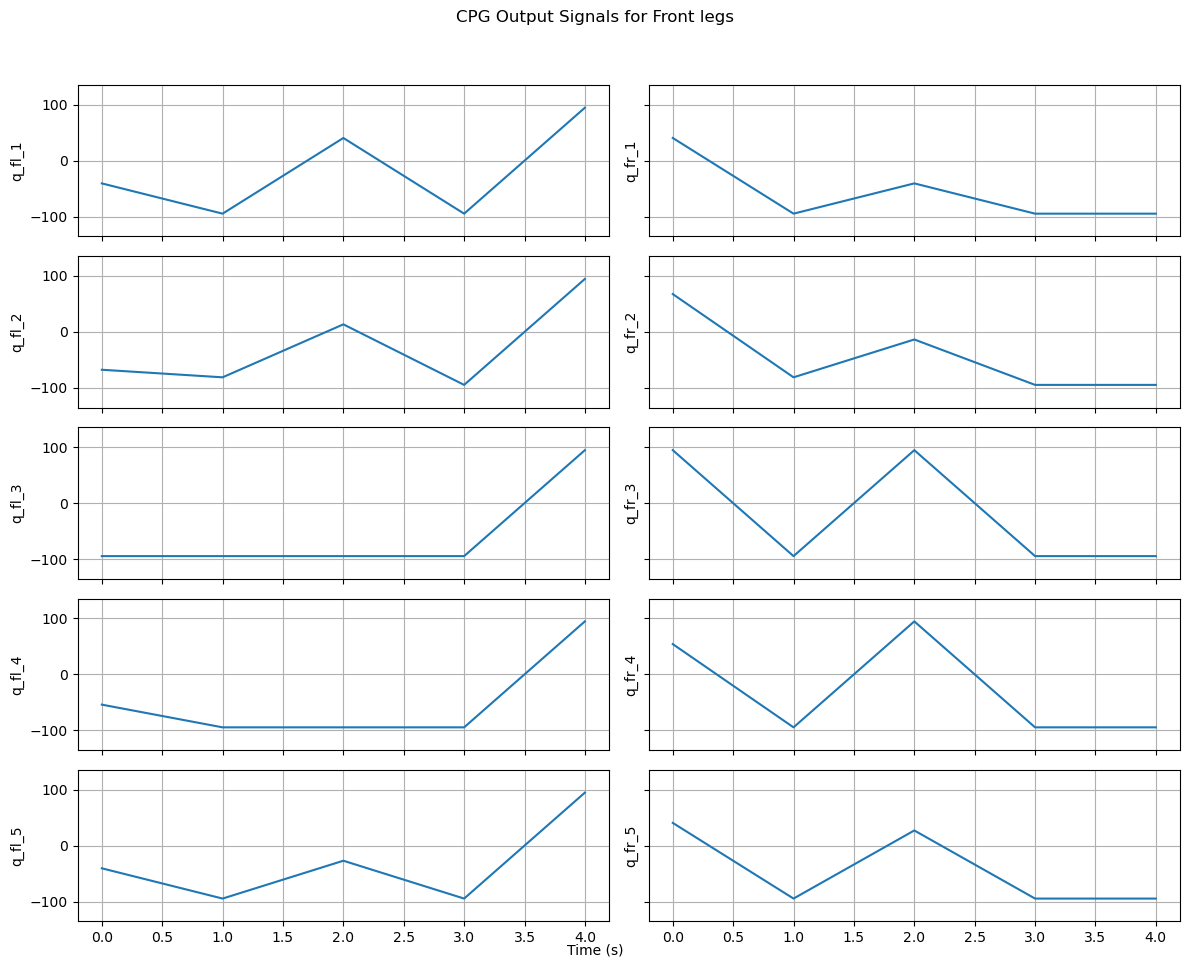

In [27]:
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot([0,1,2,3,4], np.array(bl[i])*135, linewidth=1.5)
    axs[i, 0].set_ylabel(f'q_bl_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot([0,1,2,3,4], np.array(br[i])*135, linewidth=1.5)
    axs[i, 1].set_ylabel(f'q_br_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Back Legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Create a figure with n rows and 2 columns
fig, axs = plt.subplots(n, 2, figsize=(12, 2 * n), sharex='col', sharey=True)

# Loop over each oscillator to plot its corresponding row
for i in range(n):
    # Left column: plots for the first dataset
    axs[i, 0].plot([0,1,2,3,4], np.array(fl[i])*135, linewidth=1.5)
    axs[i, 0].set_ylabel(f'q_fl_{i+1}')
    axs[i, 0].grid(True)
    axs[i, 0].set_ylim(-135, 135)
    
    # Right column: plots for the second dataset
    axs[i, 1].plot([0,1,2,3,4], np.array(fr[i])*135, linewidth=1.5)
    axs[i, 1].set_ylabel(f'q_fr_{i+1}')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(-135, 135)

# Add a common x-label and a title for the entire figure
fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.suptitle('CPG Output Signals for Front legs', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
await asyncio.sleep(1)

In [ ]:
BL.send_exe(f"esp.flag=False")
BR.send_exe(f"esp.flag=False")
FL.send_exe(f"esp.flag=False")
FR.send_exe(f"esp.flag=False")

In [ ]:
pps = int(2*np.pi/(phi_BR[11,1]-phi_BR[10,1]))

lBL = desired_angle_BL_normalized[2*pps:3*pps:1,:].tolist()
lBR = desired_angle_BR_normalized[2*pps:3*pps:1,:].tolist()
lFL = desired_angle_FL_normalized[2*pps:3*pps:1,:].tolist()
lFR = desired_angle_FR_normalized[2*pps:3*pps:1,:].tolist()

BL.send_exe(f"esp.ta=loop.create_task(from_li({lBL},0.05,5))")
BR.send_exe(f"esp.ta=loop.create_task(from_li({lBR},0.05,5))")
FL.send_exe(f"esp.ta=loop.create_task(from_li({lFL},0.05,5))")
FR.send_exe(f"esp.ta=loop.create_task(from_li({lFR},0.05,5))")

In [ ]:
BL.send_exe(f"esp.ta=loop.create_task(from_li({lBL},0.05,5))")
BR.send_exe(f"esp.ta=loop.create_task(from_li({lBR},0.05,5))")

In [ ]:
# li = [0.5353, 0.6667, -0.533, -0.6296, 0.6667]
# BR.send_exe(f"esp.pca_moves({li})")

In [ ]:
# InitL = np.array([3, 3, 3, 3, 3])*(1/135)
# # InitR = np.array([-12, -12, -12, -12, -12])*(1/135)
# BL.send_exe(f"esp.pca_moves({InitL.tolist()})")
# BR.send_exe(f"esp.pca_moves({InitR.tolist()})")

In [ ]:
break

In [ ]:
BL.send_exe(f"esp.ta.cancel()")
BR.send_exe(f"esp.ta.cancel()")
FL.send_exe(f"esp.ta.cancel()")
FR.send_exe(f"esp.ta.cancel()")